# (ALT) Google Maps Visualization

In [15]:
import gmplot 

gmap3 = gmplot.GoogleMapPlotter( 41.148522, -8.585676, 15) 
  
# trip0
latitude_list0 = [41.148522, 41.148639, 41.148855, 41.148927, 41.148963 , 41.148954, 41.14872, 41.147847, 41.14746, 41.147154, 41.146623] 
longitude_list0 = [ -8.585676, -8.585712, -8.585685, -8.58573 , -8.585982, -8.586396, -8.586072, -8.586324, -8.586999, -8.586576, -8.584884 ] 
gmap3.scatter( latitude_list0, longitude_list0, '# FF0000', size = 2.5, marker = False ) 
gmap3.plot(latitude_list0, longitude_list0, 'cornflowerblue', edge_width = 2.5) 
  
gmap3.draw( "map.html" )

# 0. Import Data

In [3]:
import csv
import math
import mplleaflet
import matplotlib.pyplot as plt
import pandas as pd
import gps_utils as gps

In [2]:
with open('../test.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')

    latitude_list = []
    longitude_list = []
    time_list = []
    # breaks only for development purposes
    counter = 0
    time = 0
    
    # for development only
    # test ist eine Liste mit allen Trajectories, jeder Traejctory ist ein (Pandas-) Dataframe mit den Spalten lon, lat, time
    test = []
    
    for row in csv_reader:
        cleared = row[8].replace("],[", " -1 ").replace("[[", "").replace("]]", "")
        if cleared != "POLYLINE":
            splitted = cleared.split(" -1 ")
            # extractes all the points
            for entry in splitted:
                data = entry.split(",")
                latitude_list.append(data[1])
                longitude_list.append(data[0])
                time_list.append(time)
                time += 15
            counter += 1
            time = 0
            # creats a trajectory dataframe
            coords = pd.DataFrame({'lon': longitude_list, 'lat': latitude_list, 'time': time_list})
            test.append(coords)
            # reset everything 
            latitude_list = []
            longitude_list = []
            time_list = []
            # breaks only for development purposes
            if counter == 6:
                break

# 1. Initial Data 

In [4]:
# retrieve the test route
coords = test[5]
coords.lon = coords.lon.astype(float)
coords.lat = coords.lat.astype(float)

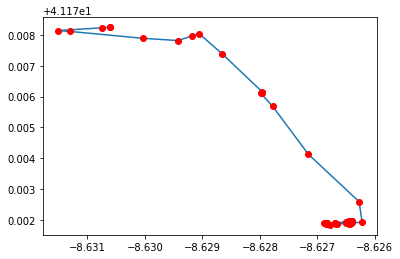

In [5]:
fig = plt.figure()
simplified_coords = coords[['lon', 'lat']].values
plt.plot(simplified_coords[:,0], simplified_coords[:,1])
plt.plot(simplified_coords[:,0], simplified_coords[:,1], 'ro')

In [6]:
mplleaflet.display(fig=fig)

/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# 2. Trajectory Partition

## 2.1. Stop Point Extraction (TDBC)
Referenz: Z. Fu, Z. Tian, Y. Xu, and C. Qiao, ‘‘A two-step clustering approach to extract locations from individual GPS trajectory data,’’ ISPRS Int. J. Geo- Inf., vol. 5, no. 10, p. 166, 2016.

Auch bei Github hochgeladen als spe-tdbc.pdf
### note: currently not working as indented
#### die Funktion stop_point_extraction() muss nur noch gefixt werden

In [7]:
print(gps.centroid(coords['lon'].tolist(), coords['lat'].tolist()))

(-8.626792113822455, 41.172497610195045)


In [8]:
def centroid(lonT, latT):
    # https://stackoverflow.com/questions/6671183/calculate-the-center-point-of-multiple-latitude-longitude-coordinate-pairs

    # lonT = [13.341664, 13.374373, 13.376003, 13.352830]
    # latT = [52.519198, 52.523039, 52.504053, 52.508498]
    
    if (len(lonT) == 0 or len(latT)== 0):
        return 0, 0

    xList = []
    yList = []
    zList = []

    dataT = pd.DataFrame({'lat': latT, 'lon': lonT})
    for index, row in dataT.iterrows():
        lat = row['lat'] * math.pi / 180
        lon = row['lon'] * math.pi / 180
        X = math.cos(lat) * math.cos(lon)
        Y = math.cos(lat) * math.sin(lon)
        Z = math.sin(lat)
        xList.append(X)
        yList.append(Y)
        zList.append(Z)

    dataXYZ = pd.DataFrame({'x': xList, 'y': yList, 'z': zList})

    x = 0
    y = 0
    z = 0
    n = 0

    for index, row in dataXYZ.iterrows():
        x += row['x']
        y += row['y']
        z += row['z']
        n += 1

    aX = x / n
    aY = y / n
    aZ = z / n

    Lon = math.atan2(y, x) * 180 / math.pi
    Hyp = math.sqrt(x * x + y * y)
    Lat = math.atan2(z, Hyp) * 180 / math.pi

    return Lon, Lat

In [1]:
def stop_point_extraction(trajectory, time_threshold, distance_threshold):
    
    # leere Cluster, c_cluster ist Cluster aus dem Paper, p_cluster ist Previous C
    c_cluster = pd.DataFrame(columns=['lon','lat','time'])
    p_cluster = pd.DataFrame(columns=['lon','lat','time'])
    stop_points = pd.DataFrame(columns=['lon','lat','time'])
    # p_point ist Previous stop point in SP aus dem Paper, relevant für Zeile 9 und 11 aus dem Paper
    p_point = None
    # Boolean Flag, nur relevant für die check Funktion
    is_type2 = False
    # braucht man nicht wirklich
    counter = 0     
    
    
    def add_stop_point(cluster):
        print("-------------------BEGIN: add_stop_point(cluster)---------------------")
        # nonlocal, damit auf die Variablen der übergeordneten Funktion aufgerufen und bearbeiten werden kann
        nonlocal p_cluster
        nonlocal stop_points
        nonlocal c_cluster
        # Variablen Initialisierung 
        p_stop_point = None
        # Nur relevant für die Initailisierung des Algorithmuses: wenn kein Stopppunkt vorhanden,
        # füge das aktuelle Cluster oder Punkt der Liste der Stopppunkte hinzu
        if len(stop_points.tail(1)['lon'].values) == 0:
            pd.concat([p_cluster,cluster]).drop_duplicates().reset_index(drop=True)
            print("--> initial SP")
        else:
            p_stop_point = stop_points.tail(1)['lon'].values[0], stop_points.tail(1)['lat'].values[0]
            cluster_coord = centroid(cluster['lon'].tolist(), cluster['lat'].tolist())
            # gps.haversine(coord1, coord2) berechnet die Distanc in Metern zwischen zwei Koordinaten
            # coord1 und coord2 müssen als Dataframe mit den Spalten lon und lat vorliegen
            if gps.haversine(cluster_coord, p_stop_point) < distance_threshold:
                # hängt alle Punkte des Clusters oder einzelnen Punkt an den p_cluster (vorheriger Cluster)
                pd.concat([p_cluster,cluster]).drop_duplicates().reset_index(drop=True)
                print("--> Added c_cluster to p_cluster")
            else:
                stop_points = stop_points.append(cluster, ignore_index=True)
                p_cluster = cluster
                # Dataframe.iloc[0:0] löscht den Inhalt eines Dataframes, hier den Inhalt von c_cluster
                c_cluster = c_cluster.iloc[0:0]
                print("---> p_cluster = cluster / drop c_cluster")
        print("-------------------END: add_stop_point(cluster)---------------------")

            
    def check():
        print("-------------------BEGIN: check()---------------------")
        nonlocal c_cluster
        nonlocal p_cluster
        nonlocal is_type2
        # centroid(coods, coords) berechnet den Mittelpunkt, Argumente, sind jeweils eine Liste von lon und lat
        c_cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
        p_cluster_coord = centroid(p_cluster['lon'].tolist(), p_cluster['lat'].tolist())
        print("---> BEFORE:")
        print(c_cluster)
        print(p_cluster)
        if (time_interval() < time_threshold and gps.haversine(c_cluster_coord, p_cluster_coord) < distance_threshold):
            # p_cluster wird erweitert mit c_cluster, Duplikate werden gelöscht
            p_cluster = p_cluster.append(c_cluster).drop_duplicates().reset_index(drop=True)
            if is_type2 == True:
                print("----> add_stop_point(p_cluster)")
                add_stop_point(p_cluster)
                is_type2 == False
            else:
                print("----> p_cluster = c_cluster / drop c_cluster")
                p_cluster = c_cluster
                # löschen des Inhalts von c_cluster
                c_cluster = c_cluster.iloc[0:0]
        print("---> AFTER:")
        print(c_cluster)
        print(p_cluster)
        print("-------------------END: check()---------------------")
            
    def time_interval():
        nonlocal c_cluster
        nonlocal p_cluster
        print(c_cluster)
        print(p_cluster)
        # wenn p_cluster leer, dann return 0 als Zeitinterval
        if p_cluster.shape[0] == 0:
            return 0
        # berechnet den Zeitinterval von zwei Clustern, indem der Maximalwert (Zeit) der beiden Cluster - Minimalwert
        min_time = min([c_cluster.iloc[[0]]['time'].tolist()[0], p_cluster.iloc[[0]]['time'].tolist()[0]])
        max_time = max([c_cluster.iloc[[-1]]['time'].tolist()[0], p_cluster.iloc[[-1]]['time'].tolist()[0]])
        return abs(max_time - min_time)
    
    def duration():
        nonlocal c_cluster
        min_time = min(c_cluster['time'].tolist())
        max_time = max(c_cluster['time'].tolist())
        return max_time - min_time
    
    p_coord = None
    for index, point in trajectory.iterrows():
        point_coord = point['lon'], point['lat']
        point_frame = pd.DataFrame({"lon": [point['lon']], "lat": [point['lat']], "time": [point['time']]})
        print("_____________________________________________________________________________")
        # adds the first and last trajectory points as type 1 stop points 
        if counter == 0 or counter == trajectory.shape[0]-1:
            add_stop_point(point_frame)
        # Lösungsvorschlag, wenn der initiale Cluster leer ist, dann füge aktuellen Punkt hinzu
        if c_cluster.shape[0] == 0:
            print(">>>c_cluster empty: put current point in c_cluster")
            c_cluster = c_cluster.append(point_frame)
        cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
        print(gps.haversine(cluster_coord, point_coord))
        print(cluster_coord, point_coord)
        # Punkte des Typ 2 sind der 1,2,3 Fall
        if gps.haversine(cluster_coord, point_coord) < distance_threshold:
            print(">>>case1: put in c_cluster")
            c_cluster = c_cluster.append(point_frame)
            cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
            is_type2 = True
        elif gps.haversine(cluster_coord, point_coord) > distance_threshold and duration() > time_threshold:
            print(">>>case2")
            add_stop_point(c_cluster) 
            is_type2 = True
        elif gps.haversine(cluster_coord, point_coord) > distance_threshold and duration() < time_threshold:
            print(">>>case3")
            check()
            is_type2 = True
        if p_coord != None and gps.haversine(p_coord, point_coord) < distance_threshold and 15 > time_threshold:
            print(">>>case4")
            is_type2 = False
            add_stop_point({p_point, point})
        if p_coord != None and gps.haversine(p_coord, point_coord) > distance_threshold and 15 > time_threshold:
            print(">>>case5")
            is_type2 = False
            pass
        
        print(c_cluster)
        print(p_cluster)
        
        counter += 1
        # p_coord (Vorherige Punkt) wird gesetzt
        p_coord = point['lon'], point['lat']
    print("ENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDEND")
    print(stop_points)


In [2]:
time_threshold = 50
distance_threshold = 10
stop_point_extraction(coords, time_threshold, distance_threshold)

NameError: name 'coords' is not defined

## 2.2. Prototype (einfacher Algorithmus)

In [14]:
coord1 = None
coord2 = None
counter = 0
points = coords.shape[0]
c_cluster = pd.DataFrame(columns=['lon','lat','time'])
p_cluster = pd.DataFrame(columns=['lon','lat','time'])
for index, row in coords.iterrows():
    coord2 = row['lat'], row['lon']
    time2 = row['time']
    if coord1 != None and gps.haversine(coord1, coord2) < 25:
        coords.drop(coords.index[[index-counter,index-counter]], inplace=True)
        counter += 1
    coord1 = row['lat'], row['lon']
    time1 = row['time']
print("{} gps points simplified to {} points".format(points, coords.shape[0]))


137 gps points simplified to 12 points


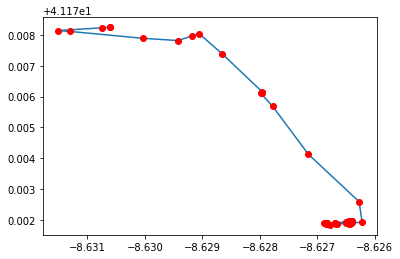

In [145]:
fig = plt.figure()
simplified_coords = coords[['lon', 'lat']].values
plt.plot(simplified_coords[:,0], simplified_coords[:,1])
plt.plot(simplified_coords[:,0], simplified_coords[:,1], 'ro')

In [111]:
mplleaflet.display(fig=fig)

/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# 3. Data Simplification 

In [112]:
simplified_coords = gps.rdp(coords[['lon', 'lat']].values, 0.00025)
print("{} gps points simplified to {} points".format(coords.shape[0], simplified_coords.shape[0]))

12 gps points simplified to 7 points


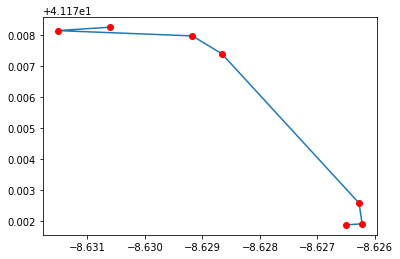

In [113]:
fig = plt.figure()
plt.plot(simplified_coords[:,0], simplified_coords[:,1])
plt.plot(simplified_coords[:,0], simplified_coords[:,1], 'ro')

In [114]:
mplleaflet.display(fig=fig)